In [1]:
import torch
from torchvision.io import read_image
import torchvision

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from math import sqrt, ceil
import os
from tqdm import tqdm
from copy import deepcopy

import sahi.predict as predict

# Import YOLOv5 helper functions
os.chdir("/home/ucloud/EUMothModel")
from tutils.yolo_helpers import non_max_suppression
from tutils.models import *

11/30/2023 10:33:35 - INFO - torch.distributed.nn.jit.instantiator -   Created a temporary directory at /tmp/tmp73_w84n4
11/30/2023 10:33:35 - INFO - torch.distributed.nn.jit.instantiator -   Writing /tmp/tmp73_w84n4/_remote_module_non_scriptable.py


In [2]:
dtype = torch.bfloat16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
# Model definition
backbone = "efficientnet_b0"
constructor = create_extendable_model_class(backbone_model=backbone)
model = constructor(path="models/run166/epoch_9_batch_final.state", device=device, dtype=dtype)
model.eval()

ExtendableModel_Hierarchical

## Helper functions

In [4]:
from sahi import ObjectPrediction, BoundingBox
from sahi.postprocess.combine import GreedyNMMPostprocess, LSNMSPostprocess
from sahi.prediction import visualize_object_predictions, PredictionScore

def ObjectPrediction_to_yolov5_format(obj, num_classes):
    # Extract bounding box and objectness score
    bbox = obj.bbox.to_voc_bbox()  # Convert to [x_min, y_min, x_max, y_max]
    x_center = (bbox[0] + bbox[2]) / 2
    y_center = (bbox[1] + bbox[3]) / 2
    width = bbox[2] - bbox[0]
    height = bbox[3] - bbox[1]
    objectness = obj.score.value

    # One-hot encode the predicted class
    class_id = obj.category.id
    class_scores = [0] * num_classes
    class_scores[class_id] = 1

    # Combine into YOLOv5 format
    yolov5_prediction = [x_center, y_center, width, height, objectness] + class_scores

    return torch.tensor(yolov5_prediction)

def convert_to_yolov5_format(object_predictions, num_classes):
    """
    Convert a list of sahi.ObjectPrediction objects to YOLOv5 prediction format.

    Args:
    - object_predictions (List[sahi.ObjectPrediction]): List of object predictions.
    - num_classes (int): Total number of classes.

    Returns:
    - List[List[float]]: Converted predictions in YOLOv5 format.
    """
    yolov5_predictions = []

    for prediction in object_predictions:
        yolov5_predictions += [ObjectPrediction_to_yolov5_format(prediction, num_classes)]    

    return torch.stack(yolov5_predictions)

def convert_to_yolov5_batch_format(yolov5_list):
    """
    Convert a list of YOLOv5 predictions to a batched YOLOv5 prediction.

    Args:
    - yolov5_list (List[List[float]]): List of YOLOv5 predictions.

    Returns:
    - torch.Tensor: Batched YOLOv5 prediction.
    """
    return torch.concat(yolov5_list)

def yolov5_to_ObjectPrediction(yp):
    """
    Convert a YOLOv5 style output to a list of sahi.ObjectPrediction objects.

    Args:
    - yp (torch.Tensor): YOLOv5 style output. Torch.Tensor of shape (n_predictions, 5 + num_classes).
    """

    object_predictions = []

    for pred in yp:
        x, y, w, h, obj = pred[:5]
        class_scores = pred[5:]

        # Convert to sahi.BoundingBox
        x_min = x - w / 2
        y_min = y - h / 2
        x_max = x + w / 2
        y_max = y + h / 2

        # Convert to sahi.Category
        category_id = class_scores.argmax().item()

        this_obj = ObjectPrediction(
            bbox=[x_min.item(), y_min.item(), x_max.item(), y_max.item()],
            category_id=category_id,
            category_name="salient_moth",
            score=obj.item()
        )

        object_predictions += [this_obj]

    return object_predictions

def plot_yolov5(yp, image, match_threshold=0.5, match_metric="IOS",**kwargs):
    object_predictions = yolov5_to_ObjectPrediction(yp)
    postprocessor = GreedyNMMPostprocess(match_threshold=match_threshold, match_metric=match_metric)
    object_predictions = postprocessor(object_predictions)
    image = np.ascontiguousarray(read_image(image).numpy().transpose(1, 2, 0), dtype=np.uint8)

    visualize_object_predictions(
        object_prediction_list=object_predictions,
        image=image,
        **kwargs
    )

def plot_list(l, image, mult=None, slice_sizes=None, conf_threshold=0.75, match_threshold=0.5, match_metric="IOS",**kwargs):
    object_predictions = []
    if mult is None:
        mult = [1] * len(l)
    for i, ol in enumerate(l):
        tl = ol.object_prediction_list
        tl = [op for op in tl if (op.score.value * mult[i]) >= conf_threshold]
        if slice_sizes is not None:
            tslice_area = slice_sizes[i] ** 2
            tl = [op for op in tl if op.bbox.area <= (tslice_area * 0.5)]

        object_predictions += tl
    postprocessor = LSNMSPostprocess(match_threshold=match_threshold, match_metric=match_metric)
    object_predictions = postprocessor(object_predictions)
    image = np.ascontiguousarray(read_image(image).numpy().transpose(1, 2, 0), dtype=np.uint8)

    visualize_object_predictions(
        object_prediction_list=object_predictions,
        image=image,
        **kwargs
    )

    out = l[0]
    out.object_prediction_list = object_predictions
    return out

def combine_and_nms(l, mult, slice_sizes, conf_threshold, match_metric, match_threshold):
    object_predictions = []
    if mult is None:
        mult = [1] * len(l)
    for i, ol in enumerate(l):
        tl = ol.object_prediction_list
        tl = [op for op in tl if (op.score.value * mult[i]) >= conf_threshold]
        if slice_sizes is not None:
            tslice_area = slice_sizes[i] ** 2
            tl = [op for op in tl if op.bbox.area <= (tslice_area * 0.5)]

        object_predictions += tl
    postprocessor = LSNMSPostprocess(match_threshold=match_threshold, match_metric=match_metric)
    object_predictions = postprocessor(object_predictions)

    out = l[0]
    out.object_prediction_list = object_predictions
    return out

## Augmentations

In [35]:
import albumentations as A

augment = A.Compose([
    A.Cutout(num_holes=4, max_h_size=32, max_w_size=32, p=0.5),
    A.GaussNoise(var_limit=(0.01, 0.05), p=0.5),
    A.Rotate(limit=45, p=1.0, rotate_method="ellipse"),
    A.VerticalFlip(p=0.5)
])

/home/ucloud/.local/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


## Model and hyperparameters

In [6]:
# ## Hyperparameters
skip = 0 # Number of batches to skip (used to resume script from a specific batch)
batch_size = 8 # Batch size for chunked loading of images
n_batches = 8 # Number of batches to load
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype=torch.bfloat16
real_class_index = 0 # The real class index of the species to fine-tune on (6 for the initial model; insectGBIF-1280m6.pt)
inference_size = 1280 # The size of the images to run inference on (1280 for the initial model; insectGBIF-1280m6.pt)
image_directory = "/home/ucloud/testCrops/Set5/"

model_weights = "insect_iter7-1280m6.pt"
pass

In [7]:
from sahi.predict import get_sliced_prediction
from sahi import AutoDetectionModel

detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov5',
    model_path="models/" + model_weights,
    config_path="models/custom5m.yaml",
    confidence_threshold=0.25,
    device=device
)

11/30/2023 10:38:46 - INFO - numexpr.utils -   Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
11/30/2023 10:38:46 - INFO - numexpr.utils -   NumExpr defaulting to 8 threads.


In [16]:
images = [image_directory + os.sep + i for i in os.listdir(image_directory) if i.endswith(".jpg")]

In [17]:
def get_image(path, size=inference_size):
    image = read_image(path, mode=torchvision.io.image.ImageReadMode.RGB)
    if size is not None:
        image = torch.functional.F.interpolate(image.unsqueeze(0), size=size, mode="bilinear")
    else:
        image = image.unsqueeze(0)
    image = image.to(device,dtype=dtype)
    return image

In [18]:
tbatch = torch.cat([get_image(i, 256) for i in images], dim=0)

In [19]:
torch.cuda.empty_cache()
# print(torch.cuda.memory_summary())
torch.cuda.memory_allocated() // 10 ** 6

176

In [13]:
# classifier_weights = list(model.classifier.parameters())

# fig, axs = plt.subplots(1, len(classifier_weights), figsize=(20, 5))

# for i, (ax, cw) in enumerate(zip(axs, classifier_weights)):
#     ax.hist(cw.float().detach().cpu().numpy().flatten(), bins=100)
#     ax.set_title(str(i))
#     ax.yaxis.set_visible(False)

In [20]:
model.toggle_embeddings(True)

False

In [21]:
with torch.no_grad():
    # t = model(torchvision.models.get_model_weights(backbone).DEFAULT.transforms()(tbatch / 255).to(dtype))
    predictions, emb = model.forward_flex(
        torchvision.models.get_model_weights(backbone).DEFAULT.transforms()(tbatch / 255).to(dtype)
    )

In [22]:
model.toggle_embeddings(False)

True

In [23]:
model.forward_flex(
        torchvision.models.get_model_weights(backbone).DEFAULT.transforms()(tbatch / 255).to(dtype),
        argmax_translate=True
    )


PREDICTION 0
Level 0 : Hyphantria_cunea_Drury_1773, Confidence: 0.7%
Level 1 : Idaea, Confidence: 5.0%
Level 2 : Noctuidae, Confidence: 36.1%
PREDICTION 1
Level 0 : Idaea_rusticata_mustelata_Gumppenberg_1892, Confidence: 2.4%
Level 1 : Idaea, Confidence: 6.4%
Level 2 : Geometridae, Confidence: 46.5%
PREDICTION 2
Level 0 : Cerura_erminea_Esper_1783, Confidence: 0.9%
Level 1 : Idaea, Confidence: 4.1%
Level 2 : Noctuidae, Confidence: 35.7%
PREDICTION 3
Level 0 : Hyphantria_cunea_Drury_1773, Confidence: 0.6%
Level 1 : Idaea, Confidence: 4.1%
Level 2 : Noctuidae, Confidence: 36.7%
PREDICTION 4
Level 0 : Sphrageidus_similis_Fssly_1775, Confidence: 0.4%
Level 1 : Idaea, Confidence: 4.0%
Level 2 : Geometridae, Confidence: 36.7%
PREDICTION 5
Level 0 : Cerura_vinula_Linnaeus_1758, Confidence: 3.2%
Level 1 : Cerura, Confidence: 4.3%
Level 2 : Noctuidae, Confidence: 30.5%
PREDICTION 6
Level 0 : Eupithecia_succenturiata_Linnaeus_1758, Confidence: 3.3%
Level 1 : Eupithecia, Confidence: 11.6%
Level 

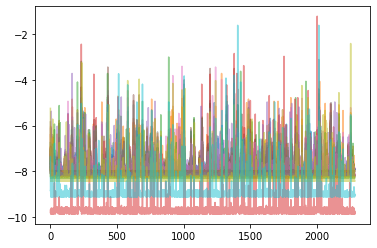

In [27]:
plt.figure()
for i in range(len(tbatch)):
    plt.gca().plot(predictions[0][i].cpu().float().numpy(), alpha=0.5)
plt.show()

In [36]:
import types

def augment_float_tensor(x):
    tx = x.clone()
    tx = tx.permute(1, 2, 0).cpu().numpy()
    tx = augment(image=tx)['image']
    tx = torch.tensor(tx).permute(2, 0, 1).to(device, dtype=dtype)
    return tx

def do_define_call_with_augment(model):
    old_call = model.__call__
    _dtype = model.parameters().__next__().dtype
    _device = model.parameters().__next__().device

    def call_with_augment(self, x, do_augment=False, n=3, **kwargs):
        if do_augment:
            xs = []
            for tx in x:
                xs += [torch.stack([tx.clone()] + [augment_float_tensor(tx.float()).to(_dtype) for _ in range(n)])]
            xs = torch.stack(xs)
            xs = xs.to(device=_device, dtype=_dtype)
            if len(xs.shape) > 4:
                augment_preds = [old_call(xsi, **kwargs) for xsi in xs]
                if self.return_embeddings:
                    augment_embeddings = torch.stack([ap[1].mean(0) for ap in augment_preds])
                    augment_preds = [ap[0] for ap in augment_preds]
                combine_pred = [torch.stack([torch.stack([ap[i][j] for j in range(n + 1)]).log_softmax(1) for ap in augment_preds]) for i in range(len(augment_preds[0]))]
                single_pred = [torch.stack([(j.float().logsumexp(0) - torch.log(torch.tensor(j.shape[0])).to(j.dtype).to(j.device)).log_softmax(0) for j in combine_pred[i]]) for i in range(len(combine_pred))]
            else:
                augment_preds = old_call(xs, **kwargs)
                if self.return_embeddings:
                    augment_embeddings = augment_preds[1].mean(0)
                    augment_preds = augment_preds[0]
                combine_pred = [torch.cat([ap[i] for ap in augment_preds]).log_softmax(0) for i in range(len(augment_preds[0]))]
                single_pred = [(j.float().logsumexp(0) - torch.log(torch.tensor(j.shape[0])).to(j.dtype).to(j.device)).log_softmax(0) for j in combine_pred]
            if self.return_embeddings:
                return single_pred, augment_embeddings
            else:
                return single_pred
        else:
            return old_call(x, **kwargs)

    model.__call__ = types.MethodType(call_with_augment, model)
    return model

model = do_define_call_with_augment(model)

In [29]:
weights = torchvision.models.get_model_weights(backbone).DEFAULT
class create_image_preprocessing:
    def __init__(self, weights):
        self.transform = weights.transforms(antialias=True)
        self.isize = self.transform.resize_size[0]
        self.mean = self.transform.mean
        self.std = self.transform.std

    def __call__(self, images):
        """Preprocess images for EfficientNet."""
        images = torchvision.transforms.Resize((self.isize, self.isize), antialias=True)(images)
        return self.transform(images)

image_preprocessing = create_image_preprocessing(weights)

In [30]:
def shannon_entropy(t):
    """
    This function computes the row-wise Shannon entropy of a tensor.
    
    Args:
    - t (torch.Tensor): Input tensor of shape (n, m).

    Returns:
    - torch.Tensor: Row-wise Shannon entropy of shape (n,).
    """

    return (-t * torch.log2(t)).sum(1)

In [31]:
import re

def bbox_predict(model, output, image, epistemic_threshold=2, background_threshold=0.3, transform=None, **kwargs):
    _dtype = model.parameters().__next__().dtype
    _device = model.parameters().__next__().device

    # print(f'dtype: {_dtype}')
    # print(f'device: {_device}')

    # Convert SAHI output to to torch.Tensor of shape (n, 4) with xmin, ymin, xmax, ymax for each bounding box
    tensor_bboxes = torch.tensor([list(i.bbox.__dict__.values())[:4] for i in output.object_prediction_list]).round().float().to(device=_device)
    tensor_image = get_image(image, size=None).float().to(device=_device)

    untransformed_inputs = torchvision.ops.roi_align(tensor_image, [tensor_bboxes], output_size=(256, 256))
    if transform is not None:
        inputs = transform(untransformed_inputs)
    inputs = inputs.to(device=_device, dtype=_dtype)
    # print(f'inputs - shape: {inputs.shape} - dtype: {inputs.dtype} - device: {inputs.device}')

    model_uses_embeddings = model.toggle_embeddings(True)
    with torch.no_grad():
        crop_pred, crop_embeddings = model.__call__(inputs, **kwargs)

    max_scores = torch.stack([crop_pred[i].max(1).values for i in range(3)])
    score_multiplier = max_scores.T.diff(1).exp()
    best_level = [torch.where(i)[0].max().item() + 1 if any(i) else 0 for i in (score_multiplier > epistemic_threshold)]

    predicted_class, predicted_class_name, prediction_confidence = [], [], []
    for i in range(len(inputs)):
        this_scores = crop_pred[best_level[i]][i]
        this_predicted_class = int(this_scores.argmax(0).int().cpu().numpy())
        this_predicted_class_name = model.class_handles["idx_to_class"][best_level[i]][this_predicted_class]
        this_prediction_confidence = this_scores.max(0).values.exp().float().cpu().numpy()

        predicted_class += [this_predicted_class]
        predicted_class_name += [this_predicted_class_name] if this_prediction_confidence > background_threshold else ["background"]
        prediction_confidence += [this_prediction_confidence]

    # Sort by class and confidence
    order = np.lexsort((prediction_confidence, predicted_class))
    untransformed_inputs = untransformed_inputs[order]
    predicted_class = [predicted_class[i] for i in order]
    predicted_class_name = [predicted_class_name[i] for i in order]
    prediction_confidence = [prediction_confidence[i] for i in order]
    crop_embeddings = crop_embeddings[order]
    best_level = [best_level[i] for i in order]

    # Restore model state
    model.toggle_embeddings(model_uses_embeddings)

    # Return the cropped tensors, predicted class level, predicted class index, predicted class name, and prediction confidence
    return untransformed_inputs, best_level, predicted_class, predicted_class_name, prediction_confidence, crop_embeddings

def plot_batch_predict(images, labels, conf, output_file="sahi/plots/crops.png", mixed=True):
    if mixed:
        # Check if there are any background predictions
        if "background" in labels:
            print("Background")
            images_background = torch.stack([i for i, l in zip(images, labels) if l == "background"])
            labels_background = [l for l in labels if l == "background"]
            conf_background = [c for c, l in zip(conf, labels) if l == "background"]
            plot_batch_predict(images_background, labels_background, conf_background, output_file=output_file.replace(".png", "_background.png"), mixed=False)

        # Check if there are any salient predictions
        if any([l != "background" for l in labels]):
            print("Salient")
            images_salient = torch.stack([i for i, l in zip(images, labels) if l != "background"])
            labels_salient = [l for l in labels if l != "background"]
            conf_salient = [c for c, l in zip(conf, labels) if l != "background"]
            plot_batch_predict(images_salient, labels_salient, conf_salient, output_file=output_file.replace(".png", "_salient.png"), mixed=False)
    else:
        # plot crops for debugging
        ncol = int(sqrt(len(images)))
        nrow = ceil(len(images) / ncol)
        assert ncol * nrow >= len(images)

        fig, axs = plt.subplots(nrow, ncol, figsize=(ncol * 2, nrow * 2))
        if (nrow, ncol) == (1, 1):
            axs = [axs]
        else:
            axs = axs.ravel()

        for ax, crop, p, s in zip(axs, images.int().cpu(), labels, conf):
            ax.imshow(crop.cpu().numpy().transpose(1, 2, 0))
            p = re.search(r"^[^_]+(_[^_]+){0,1}", p).group(0) if p != "background" else p
            p = p.replace("_", "\n")
            ax.set_title(f"{p}\n({100 * s:.1f}%)")
            ax.axis("off")
        # Set unused axes to invisible
        for ax in axs[len(images):]:
            ax.axis("off")
            ax.set_visible(False)

        plt.tight_layout()
        fig.patch.set_facecolor("white")
        plt.savefig(output_file, dpi=300)
        plt.close()

In [32]:
slice_sizes = np.arange(256, 512 + 1, 128).tolist()

pbar = tqdm(enumerate([images[0]]), total=len(images))

for image_idx, this_image in pbar:
    pbar.set_description(f"Processing image {image_idx + 1} of {len(images)} ({this_image.split(os.sep)[-1]})")
    torch.cuda.empty_cache()
    # Perform localization on the image
    these_predictions = [
        get_sliced_prediction(
        this_image,
        detection_model,
        slice_height=i,
        slice_width=i,
        perform_standard_pred=False,
        postprocess_type="GREEDYNMM",
        postprocess_match_threshold=1,
        overlap_height_ratio=0.25,
        overlap_width_ratio=0.25,
        verbose=0
        )
        for i in slice_sizes
    ]

    # Combine predictions
    this_combined_prediction = combine_and_nms(these_predictions, None, slice_sizes, 0.8, "IOS", 0.1)

    # Perform bounding box classification
    crops, plevel, pclass, pclass_name, pconfidence, embeddings = bbox_predict(
        model, this_combined_prediction, this_image, 
        epistemic_threshold=10,
        background_threshold=0, 
        transform=lambda x : image_preprocessing(x / 255.0),
        do_augment=False,
        n=25
    )

    # Plot the crops
    this_image_name = this_image.split(os.sep)[-1].split(".")[0]
    plot_batch_predict(crops, pclass_name, pconfidence, output_file=f"sahi/inference/{this_image_name}.png")

Processing image 1 of 20 (SS2 - 20230626030000-167-snapshot.jpg):   0%|          | 0/20 [00:00<?, ?it/s]11/30/2023 10:41:29 - WARNING - sahi.postprocess.combine -   LSNMSPostprocess is experimental and not recommended to use.


Salient


Processing image 1 of 20 (SS2 - 20230626030000-167-snapshot.jpg):   5%|▌         | 1/20 [00:27<08:40, 27.38s/it]


In [38]:
# Perform bounding box classification
crops, plevel, pclass, pclass_name, pconfidence, embeddings = bbox_predict(
    model, this_combined_prediction, this_image, 
    epistemic_threshold=10,
    background_threshold=0, 
    transform=lambda x : image_preprocessing(x / 255.0),
    do_augment=False,
    n=25
)

# Plot the crops
this_image_name = this_image.split(os.sep)[-1].split(".")[0]
plot_batch_predict(crops, pclass_name, pconfidence, output_file=f"sahi/inference/{this_image_name}.png")

Salient


In [25]:
import matplotlib as mpl

plt.close()

fig, axs = plt.subplots(6, 6, figsize=(24, 24))

for i, (ax, crop, p, s) in enumerate(zip(axs.flatten(), crops[:36].int().cpu(), pclass_name, pconfidence)):
    ax.imshow(crop.cpu().numpy().transpose(1, 2, 0))
    p = re.search(r"^[^_]+(_[^_]+){0,1}", p).group(0) if s > 0.1 else "background"
    p = p.replace("_", "\n")
    ax.set_title(f"{p}\n({100 * s:.1f}%) - {i}")
    ax.axis("off")

plt.tight_layout()
fig.patch.set_facecolor("white")
plt.savefig("sahi/inference/crops.png", dpi=300)
plt.close()

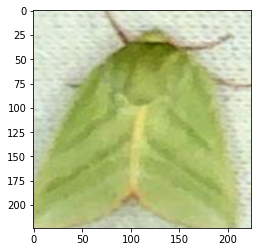

In [51]:
orig_do_augment = model.toggle_embeddings(True)

with torch.no_grad():
    test_crop = crops[-8].clone()

    test_crop = test_crop / 255.0
    test_crop = image_preprocessing(test_crop)
    tout, temb = model.__call__(test_crop.unsqueeze(0).to(dtype), do_augment=True, n = 25)

model.toggle_embeddings(orig_do_augment)

test_crop_img = test_crop - test_crop.min()
test_crop_img = test_crop_img / test_crop_img.max()
plt.imshow(test_crop_img.cpu().permute(1, 2, 0).numpy())

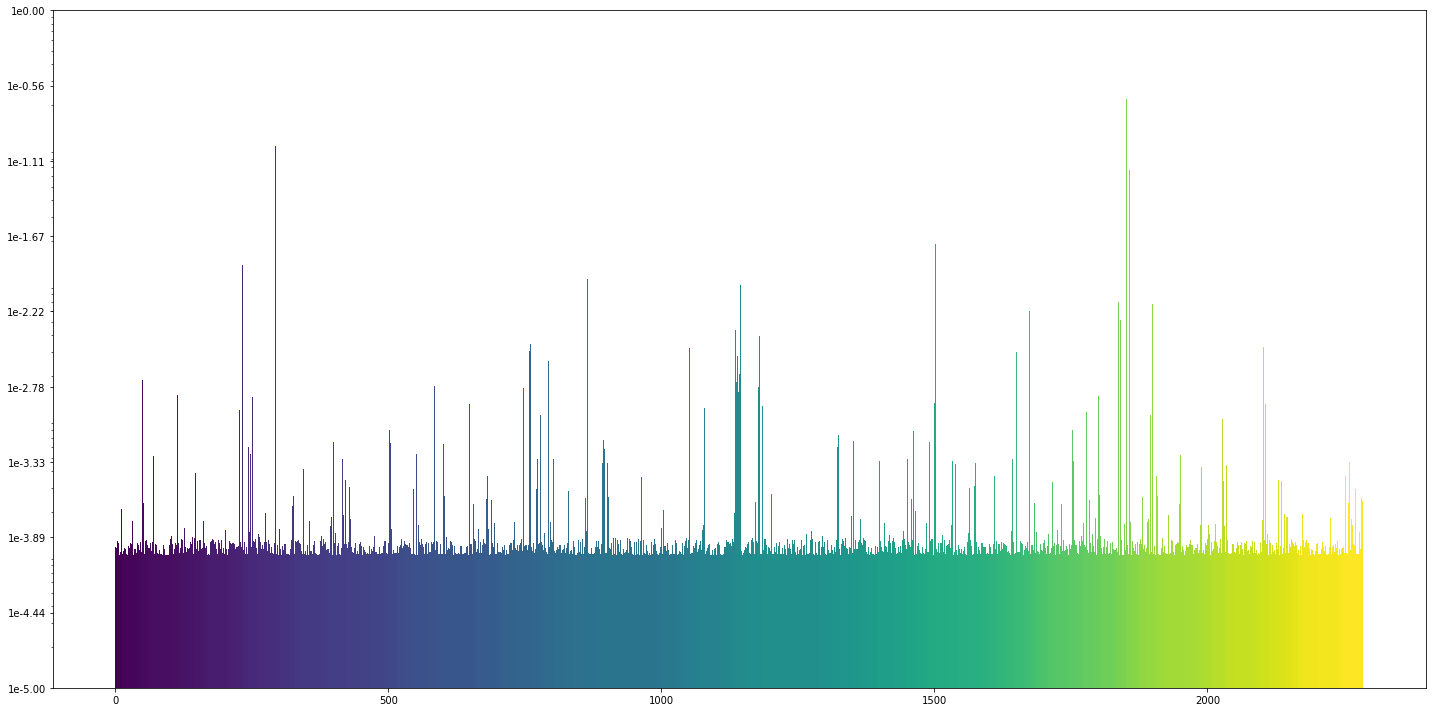

In [52]:
plt.figure(figsize=(20, 10))
# Viridis
cmap = mpl.colormaps['viridis']
# Calculate values to use for colors
values_for_colormap = torch.where(model.classifier.masks[0] > -1)[0].cpu() / model.classifier.masks[0].shape[0]
# Map to colors
colors = [cmap(i.item()) for i in values_for_colormap]
# Convert to RGB
colors = [mpl.colors.to_rgb(i) for i in colors]
# Convert to hex
colors = [mpl.colors.to_hex(i) for i in colors]
# Calculate heights (y-values)
ys = tout[0].cpu().float().squeeze(0)
ys10 = ys / torch.log(torch.tensor(10.0)).to(ys.dtype).to(ys.device)
# Arrange x-values
xs = np.arange(ys.shape[0])
# Plot
plt.bar(
    x       =   xs, 
    height  =   ys.exp(),
    width   =   1,
    color   =   colors,
)
plt.yscale("log")
plt.gca().set_yticks(torch.logspace(ys10.min().floor(), ys10.max().ceil(), 10), minor=False, labels=[f"1e{torch.log10(i):.2f}" for i in torch.logspace(ys10.min().floor(), ys10.max().ceil(), 10)])
plt.tight_layout()
plt.show()

In [87]:
import time

orig_do_augment = model.toggle_embeddings(True)

with torch.no_grad():
    test_crop = crops.clone()

    test_crop = test_crop / 255.0
    test_crop = image_preprocessing(test_crop)
    start_time = time.time()
    # tout, temb = model(test_crop.to(dtype))
    tout, temb = model.__call__(test_crop.to(dtype), do_augment=False, n = 25)
    end_time = time.time()

print(f"Time taken: {end_time - start_time:.2f} seconds")

model.toggle_embeddings(orig_do_augment)

Time taken: 23.19 seconds


True

In [88]:
plt.close()

plt.figure(figsize=(12, 6))
ax = plt.gca()
plt.imshow(tout[0].exp().float().cpu().numpy(), interpolation="nearest", cmap="magma", norm=mpl.colors.LogNorm())
ax.set_aspect("auto")

plt.colorbar()

plt.tight_layout()
# Set background to white
ax.patch.set_alpha(1)
ax.patch.set_facecolor("white")
plt.savefig("sahi/plots/test1.png", dpi=300)
plt.close()

In [89]:
plt.close()

plt.figure(figsize=(12, 6))
plt.scatter(*torch.pca_lowrank(tout[0].float(), 2)[0].cpu().numpy().transpose())
plt.gca().set_aspect("equal")

plt.tight_layout()
plt.savefig("sahi/plots/test2.png", dpi=300)
plt.close()

In [39]:
[f'{model.class_handles["idx_to_class"][0][i.argmax(0).int().item()]} ({i.max().exp().item() * 100:.1f}%)' for i in tout[0]]

['Acherontia_atropos_Linnaeus_1758 (64.5%)',
 'Pterostoma_palpina_Clerck_1759 (1.9%)',
 'Allophyes_oxyacanthae_Linnaeus_1758 (23.5%)',
 'Aplocera_praeformata_Hbner (2.4%)',
 'Catocala_hymenaea_Denis_Schiffermller_1775 (3.5%)',
 'Coranarta_cordigera_Thunberg_1788 (5.6%)',
 'Coscinia_cribraria_Linnaeus_1758 (43.9%)',
 'Coscinia_cribraria_Linnaeus_1758 (57.0%)',
 'Drepana_falcataria_Linnaeus_1758 (98.0%)',
 'Eilema_lutarella_Linnaeus_1758 (9.8%)',
 'Eilema_lutarella_Linnaeus_1758 (38.5%)',
 'Euplexia_lucipara_Linnaeus_1758 (8.0%)',
 'Hyles_euphorbiae_Linnaeus_1758 (13.6%)',
 'Hyles_livornica_Esper_1780 (13.1%)',
 'Idaea_trigeminata_Haworth_1809 (23.5%)',
 'Lymantria_monacha_Linnaeus_1758 (31.1%)',
 'Marumba_quercus_Denis_Schiffermller_1775 (23.3%)',
 'Nycteola_revayana_Scopoli_1772 (45.5%)',
 'Pachycnemia_hippocastanaria_Hbner_1799 (66.8%)',
 'Phragmataecia_castaneae_Hbner_1790 (25.4%)',
 'Phragmataecia_castaneae_Hbner_1790 (75.8%)',
 'Schrankia_costaestrigalis_Stephens_1834 (27.0%)',
 'V

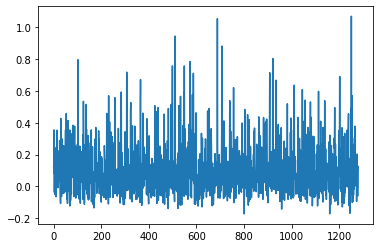

In [40]:
plt.plot(embeddings.mean(0).cpu().float())

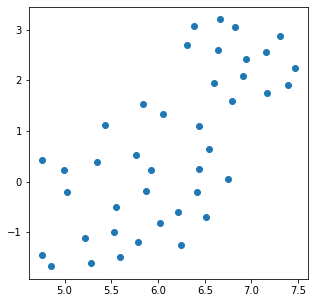

In [92]:
# crop_ord = torch.pca_lowrank(test_crop_inf[1].float(), 2)[0]
# Try umap for testing
import umap
import matplotlib as mpl
crop_ord = umap.UMAP(
    n_components=2, 
    metric = "euclidean", 
    min_dist = 0.05, 
    n_neighbors = 15
).fit_transform(
    # embeddings.float().cpu()  
    (embeddings / embeddings.sum(1, keepdim=True)).float().cpu()
)
crop_ord = torch.tensor(crop_ord)

plt.figure(figsize=(5, 5))
plt.scatter(*crop_ord.cpu().T)
plt.savefig("sahi/plots/crop_pca.png", dpi=300)

# Plot each crop at the PCA coordinates, in a sort of "scatterplot" of the crops
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

crop_ord_screen_coords = crop_ord.clone()
crop_ord_screen_coords -= crop_ord_screen_coords.min(0, keepdim=True).values
crop_ord_screen_coords /= crop_ord_screen_coords.max(0, keepdim=True).values

plt.figure(figsize=(30, 30))
ax = plt.gca()

# define colormap for classes
cmap = mpl.colormaps['tab20']
norm = mpl.colors.Normalize(vmin=0, vmax=len(set(pclass_name)))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

for i, (x, y) in enumerate(crop_ord_screen_coords.cpu()):
    image = crops[i].int().cpu().numpy().transpose(1, 2, 0)
    conf = pconfidence[i].item()  # Prediction confidence

    # Adjust the alpha of the image based on the confidence
    im = OffsetImage(image, zoom=0.25, alpha=1)  # Adjust zoom as needed
    box_color = list(cmap.to_rgba(pclass[i])) if pclass_name[i] != "background" else [0, 0, 0, 0]
    box_color[3] = conf  # Adjust alpha based on confidence

    # Create an annotation box with adjusted alpha for the border
    bboxprops = dict(edgecolor=box_color, linewidth=3)  # Add confidence to the RGBA tuple
    ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=True, pad=0.1, boxcoords="offset points", bboxprops=bboxprops)
    ax.add_artist(ab)

    # Extract and format the box label
    box_label = re.search(r"^[^_]+(_[^_]+){0,1}", pclass_name[i]).group(0)
    box_label = box_label.replace("_", "\n")

    # Adjust these parameters to position the annotation above the box
    text_offset = 20  # Adjust this value as needed
    # Adjust the alpha of the text and its background based on confidence
    if pclass_name[i] != "background":
        ax.annotate(box_label, (x, y), xycoords='data', xytext=(0, text_offset), textcoords='offset points', ha="center", va="bottom", fontsize=12, color="black", bbox=dict(boxstyle="round", fc=box_color, ec="none", alpha=conf))

plt.savefig("sahi/plots/crop_pca_scatter.png", dpi=300)
plt.close()